In [6]:
#############################
### Import libraries ###
#############################

from docplex.cp.model import *

import numpy as np
from sklearn import tree
from matplotlib import pyplot as plt


In [7]:
#############################
### Essentials functions ###
#############################
import decision_tree as dt
import sys
sys.path.append("..")
import FunctionMain as fm
from Solver import *
from User import *

In [8]:
# ----------------- Parameters

# The file to consider
file = '../file_with_optimal_val/la04.txt'

# The number of solutions that we will have in the solver during the first iteration
k = 20

# The number of layer which is fixed
nb_layers = 5

# Variable which display the solution
display_sol = False

# Variable which display the start (in a vector)
display_start = False

# Variable which display the start (in a matrix)
display_matrix = False

# Time stop criterion 
tps_max = 300

# Number of iteration stop criterion
it_max = 15




# The number of solutions that we will have in the solver after the first iteration
k_k = 15

# List of different search type (for the solver)
list_search_type = ["DepthFirst", "Restart", "MultiPoint", "IterativeDiving"]

#############################
### Main program ###
#############################

print("\n--------Main program is loading...---------")

# --------- Interaction with the solver
data = []

# --------- Get essential informations from the file
n, m, data, T_machine, T_duration, duration, optimalval = fm.get_data_from_file(file)

# --------- Call Solver constructor in Solver.py and create the variables of the model
model, solver, starts = fm.initialize_solver(data, n, m, duration)

# --------- Create the constraints of the model
model, variables = solver.create_constraints(model, n, m, optimalval, T_machine)

# ------------ Solve the model
print("\nSolving the model...")
msol, nb_solution, runtime = solver.solve(model, k_k, n, m, variables)

# ------------ Display the result
fm.display_solution(msol, display_sol)
print("Model solved !")

# ---------------- Interaction with the user
print("\n--------Interaction with the user...---------")
print("\nCreating the user...")
user = User()
print("User created !")

# Get the variables of the model
variables = solver.get_variables()

# Get the list of the preferences of the user
list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers, n, m)

# Vector of the start time of each task of each preference
starts = user.start_pref(n, m, display_start)

# Matrix of the start time of each task of each preference
matrix = user.matrix_pref(n, m, display_matrix)

# Testing the order of preferences and the differences between solutions
fm.test(n, m, user)

print("list layers : ",list_layers)



--------Main program is loading...---------

Creating the model variables...
Model tasks_by_jobs created !

Solver initialized !

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraints to the solver...
Disjunctive constraints added !

Solving the model...
Model solved !

--------Interaction with the user...---------

Creating the user...
User created !

Classing solutions...
Le min de list_obj est 3881
Le max de list_obj est 5301
Solutions classed !

Creating preferences...
Preferences created !

Testing order of preferences...
	L'ordre des préférences n'est pas cohérente

Testing differences between solutions...
	Toutes les solutions sont différentes
list layers :  [[<docplex.cp.solution.CpoSolveResult object at 0x7fe123b285c0>, <docplex.cp.solution.CpoSolveResult object at 0x7fe1130a0040>, <docplex.cp.solution.CpoSolveResult object at 0x7fe1169f9e40>], [<docplex.cp.solution.CpoSolveResult object at 0x7fe126ecb4c0>, <docplex.cp.s

In [9]:
####################################################################
#### Arbre de décision : RECHERCHE DE NOUVELLES SOLUTIONS 
####################################################################


###  -------------- Iteration of the solver with the preferences
# Initialization of the counter of iteration
it = 1
# Initialization of the counter of time
tps = runtime
# Initialization of the list of the objective function (that we would like to plot later)
list_min_obj = [min(list_obj)]
# Initialization of the list of the objective function globally (that we would like to plot later)
list_min_obj_global = [min(list_obj)]
# Initialization of the stop criterion
criterion = (tps < tps_max) and (it < it_max) 

# ----------------- The loop for the problem (until a stop criterion is reached)
while criterion :
    
    print("\n--------Iteration {}---------".format(it))
    it += 1

     # --------- Compute decision trees---------------
    clf, feuilles_conditions = dt.my_decision_tree(n, m, list_layers)
    # Implementation of the decision tree

    # print("\n--------Implementation of the decision tree...---------")
    # print(len(feuilles_conditions)) 
    # fig = plt.figure(figsize=(10,7))
    # _ = tree.plot_tree(clf, 
    #                     class_names= ("not best layer (0)", "best layer (1)" ), 
    #                     filled=True)
    
    # --------- Call Solver constructor in Solver.py and create the variables of the model
    model, solver, starts = fm.initialize_solver(data, n, m, duration)

    # --------- Add the new constraints to the model (that solution must be different from the previous generated solutions)
    variables = fm.update_variables_new_constraint(n, m,  pref, model, solver)
    
    
      
    #----------Add new variable "order" to the model---------------
    order = model.binary_var(name="order")
    solver.add_variable(order)
    
   
    # --------- Add the new constraints to the model (concerning the order)
    list_variables = [model.start_of(variables[i//m][i%m]) for i in range(n*m)]
    # Add the constraints related to the decision tree
    constraint_list_of_tree = dt.constraint_tree(order,list_variables, feuilles_conditions)

    # Iteration in the list of constraints
    for constraint in constraint_list_of_tree:
        solver.add_constraint(model, constraint)
    solver.add_constraint(model, equal(order, 1))


    model, variables = solver.create_constraints(model, n, m, optimalval, T_machine)

    # ------------ Solve the model
    print("\nSolving the model...")
    msol, nb_solution, runtime = solver.solve(model, k_k, n, m, variables)

    print("The number of solutions generated is :",nb_solution)

    # Adding the objective value of each solution to a list
    list = []
    for sol in msol:
        list.append(user.objectiveFunction(sol) + user.objectiveFunctionRegularity(sol, n, m))

    # ------------ Adding the min of objective function among the solutions generated to 
    # the list of objective function (for later display)
    list_min_obj.append(min(list))
    print("Objective function :", list_min_obj)

    # ------------ Display the result
    fm.display_solution(msol, display_sol)
    print("Model solved !")

    # ---------------- Interaction with the user
    list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers, n, m)
    print("Il y a {} solution(s)".format(len(pref)))

    # ------------ Adding the min of objective function among all solutions generated to 
    # the list of objective function (for later display)
    list_min_obj_global.append(min(list_obj))
    print("Objective function global :", list_min_obj_global)

    # Vector of the start time of each task of each preference
    starts = user.start_pref(n, m, display_start)

    # Matrix of the start time of each task of each preference
    matrix = user.matrix_pref(n, m, display_matrix)

    # Testing the order of preferences and the differences between solutions
    fm.test(n, m, user)

#------------------ Stop criterion ------------------
    tps += runtime
    criterion = (tps < tps_max) and (it < it_max) 
    fm.stopCondition(it, it_max, tps, tps_max)


--------Iteration 1---------
best score:  1.0

Creating the model variables...
Model tasks_by_jobs created !

Solver initialized !
['18 <= 587.5', 1]
<class 'list'>
['18 > 587.5', 0]
<class 'list'>

Solving the model...

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraints to the solver...
Disjunctive constraints added !
The number of solutions generated is : 8666
Objective function : [3881, 3211]
Model solved !

Classing solutions...
Le min de list_obj est 3211
Le max de list_obj est 5301
Solutions classed !

Creating preferences...
Preferences created !
Il y a 30 solution(s)
Objective function global : [3881, 3211]

Testing order of preferences...
	L'ordre des préférences n'est pas cohérente

Testing differences between solutions...
	Toutes les solutions sont différentes

--------Iteration 2---------
best score:  1.0

Creating the model variables...
Model tasks_by_jobs created !

Solver initialized !
['40 <= 212.25876193133126


--------Implementation of the decision tree...---------
11


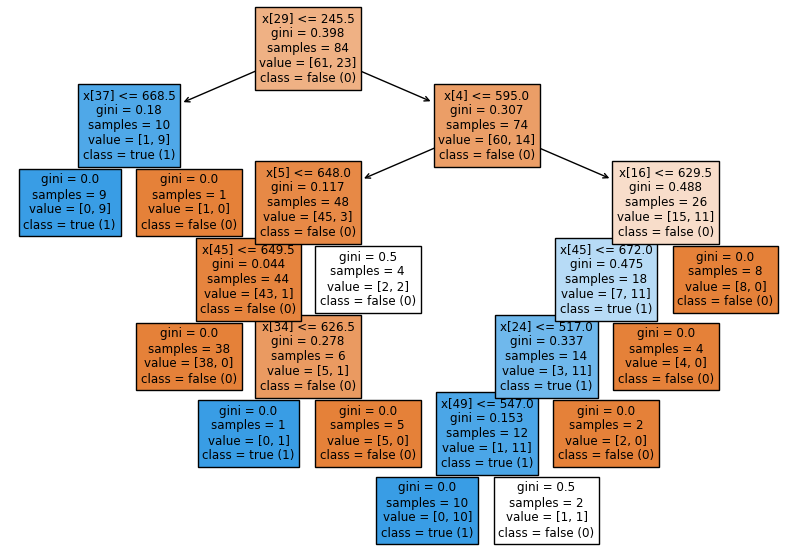

In [10]:
# Implementation of the decision tree

print("\n--------Implementation of the decision tree...---------")
print(len(feuilles_conditions)) 
fig = plt.figure(figsize=(10,7))
_ = tree.plot_tree(clf, 
                    class_names= ("false (0)", "true (1)" ), 
                    filled=True)

[3881, 3211, 4579, 4043, 7115, 3526, 3938, 3934]


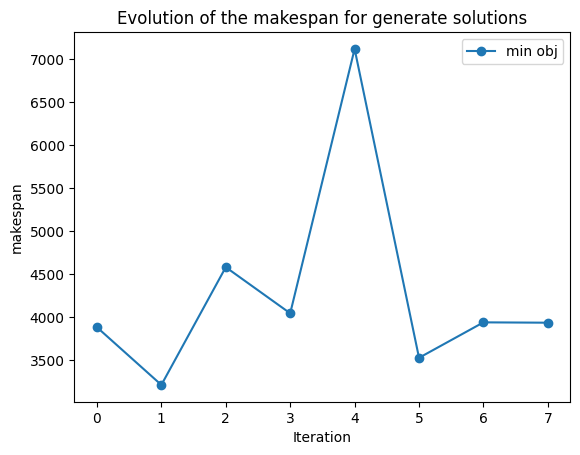

In [11]:
# Plot the minimum objective among the solutions generated so far

import matplotlib.pyplot as plt
print(list_min_obj)
plt.plot([i for i in range(it)], list_min_obj, label='min obj', marker='o')
plt.xlabel("Iteration")
plt.ylabel("makespan")
plt.title("Evolution of the makespan for generate solutions")
plt.xticks(range(it))
plt.legend()
plt.show() 

[3881, 3211, 3211, 3211, 3211, 3211, 3211, 3211]


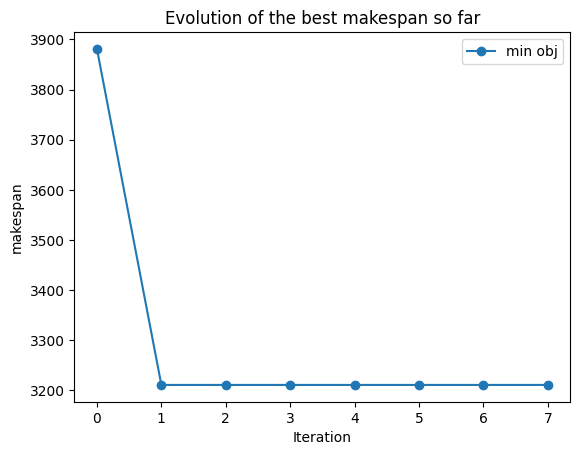

In [12]:
# Plot the minimum objective among all the solutions generated so far

print(list_min_obj_global)
plt.plot([i for i in range(it)], list_min_obj_global, label='min obj', marker='o')
plt.xlabel("Iteration")
plt.ylabel("makespan")
plt.title("Evolution of the best makespan so far")
plt.xticks(range(it))
plt.legend()
plt.show() 

In [14]:
# import main_dt as cdt
# list_min_obj, list_min_obj_global = cdt.main_dt({},'../file_with_optimal_val/la04.txt', "test0", 5, 20, 15, 100, 10, "plus")


--------Main program is loading...---------

Creating the model variables...
Model tasks_by_jobs created !

Solver initialized !

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraints to the solver...
Disjunctive constraints added !

Solving the model...


CpoSolverException: Exception caught from CP solver: 